In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model

Using TensorFlow backend.


In [ ]:
import random as rn
import numpy as np

np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers:
    layer.trainable = False 
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000174F863F908> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174F83183C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174F8658548> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000174FB8CF108> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174FB8CF188> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174FB8E5248> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000174FB8F2808> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174FB900C88> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174FB905988> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000174FB918F88> False
<tensorflow.python.keras.la

In [8]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
]

def make_model(metrics = METRICS, output_bias=None):
  
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  headModel = vgg_conv.output
  headModel = keras.layers.Flatten(name="flatten")(headModel)
  # headModel = keras.layers.Dense(512, activation="relu")(headModel)
  # headModel = keras.layers.Dropout(0.5)(headModel)
  headModel = keras.layers.Dense(512, activation="relu")(headModel)
  headModel = keras.layers.Dropout(0.5)(headModel)
  headModel = keras.layers.Dense(1, activation="sigmoid")(headModel)

  model = Model(inputs=vgg_conv.input, outputs=headModel)

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-5),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model


In [6]:
pos = 173
neg = 727
initial_bias = np.log([pos/neg])
print(initial_bias)

[-1.43563488]


In [9]:
model = make_model(output_bias=initial_bias)
#model.save_weights('initial_weights_1fc_256.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [155]:
train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batchsize = 64
val_batchsize = 16
train_generator = train_datagen.flow_from_directory(
        directory="/content/Dataset2/train2",
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='binary', 
        shuffle=True,
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        directory="/content/Dataset2/valid2",
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='binary',
        shuffle=False, 
        seed=42)


Found 766 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [157]:
pos = 173
neg = 727
total = 900
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
 
class_weight = {0: weight_for_0, 1: weight_for_1}

print(weight_for_0)
print(weight_for_1)

0.6189821182943603
2.6011560693641615


In [ ]:
# Optional Finetuning

#model.load_weights('/content/vgg16_1fc512_head_038.h5')
for layer in vgg_conv.layers:
    layer.trainable = True 
for layer2 in model.layers:
    print(layer2, layer2.trainable)

opt = keras.optimizers.Adam(lr=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [159]:
# Train the model

#model = make_model()
model.load_weights('/content/vgg16_1fc256_head_003.h5')
#model = load_model("/content/vgg16_1fc256_head_003.h5")

checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg16_1fc256_head_{epoch:03d}.h5', monitor='val_precision', verbose=1, save_best_only=True,  mode='max', save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
history = model.fit(
      train_generator,
      epochs=100,
      class_weight=class_weight,
      validation_data=validation_generator,
      callbacks=[checkpoint,early],
      verbose=1, 
      use_multiprocessing=False,
      max_queue_size=10,                # maximum size for the generator queue
      workers=1,  
      )


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 3.4351 - accuracy: 0.5574 - precision: 0.2333 - recall: 0.5714 - auc: 0.5836 - tp: 84.0000 - fp: 276.0000
Epoch 00001: val_precision improved from -inf to 0.32727, saving model to grafico_1fc256_head_001.h5
12/12 [==============================] - 48s 4s/step - loss: 3.4351 - accuracy: 0.5574 - precision: 0.2333 - recall: 0.5714 - auc: 0.5836 - tp: 84.0000 - fp: 276.0000 - val_loss: 1.2616 - val_accuracy: 0.6642 - val_precision: 0.3273 - val_recall: 0.6923 - val_auc: 0.7010 - val_tp: 18.0000 - val_fp: 37.0000
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 3.2839 - accuracy: 0.5640 - precision: 0.2336 - recall: 0.5578 - auc: 0.5810 - tp: 82.0000 - fp: 269.0000
Epoch 00002: val_precision improved from 0.32727 to 0.33333, saving model to grafico_1fc256_head_002.h5
12/12 [==============================] - 47s 4s/step - loss: 3.2839 - accuracy: 0.5640 - precision: 0.2336 - recall: 0.5578 - auc: 0.5810

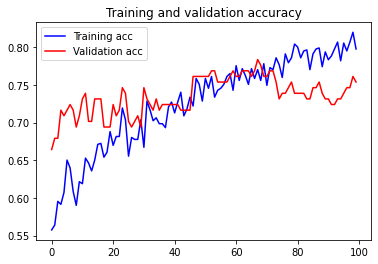

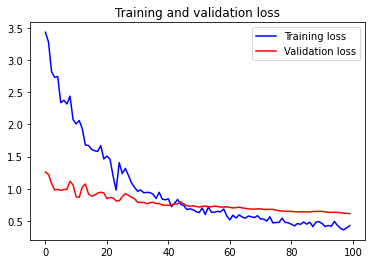

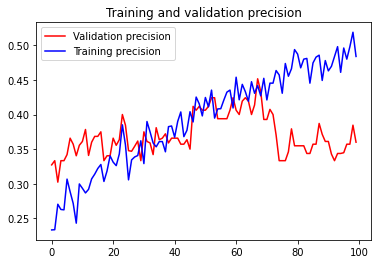

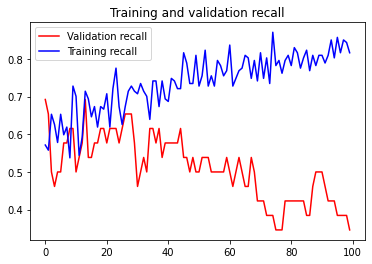

In [160]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_precision = history.history['val_precision']
precision = history.history['precision']
val_recall = history.history['val_recall']
recall = history.history['recall']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.plot(epochs, precision, 'b', label='Training precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.plot(epochs, recall, 'b', label='Training recall')
plt.title('Training and validation recall')
plt.legend()


plt.show()


In [161]:
tsdata = ImageDataGenerator(preprocessing_function=preprocess_input)
from sklearn.metrics import classification_report, confusion_matrix

test_generator = tsdata.flow_from_directory(directory="/content/Dataset/test", target_size=(224,224), class_mode='binary',shuffle=False, batch_size=1, seed=42)

model.load_weights('/content/vgg16_1fc256_head_068.h5')
results = model.evaluate(test_generator)
print(results)

test_generator.reset()
predIdxs = model.predict(test_generator)
predictions = predIdxs >=0.5

print(classification_report(test_generator.classes, predictions, target_names=test_generator.class_indices.keys()))
print("Confusion Matrix:")
print(confusion_matrix(test_generator.classes, predictions))



Found 389 images belonging to 2 classes.
389/389 [==============================] - 23s 59ms/step - loss: 0.5496 - accuracy: 0.7866 - precision: 0.4545 - recall: 0.5333 - auc: 0.7528 - tp: 40.0000 - fp: 48.0000
[0.5496485233306885, 0.7866324186325073, 0.4545454680919647, 0.5333333611488342, 0.7528237104415894, 40.0, 48.0]
